In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [17]:
%reload_ext autoreload
%autoreload 2
import methods

# Objectif : ajouter une dépendance temporelle dans la fonction Campbelle

#### Dans un premier temps, nous allons simuler des données d'entrées, ces données ont maintenant une dépendance temporelle. Nous allons aussi ajouter une notion de périodicité dans les données.

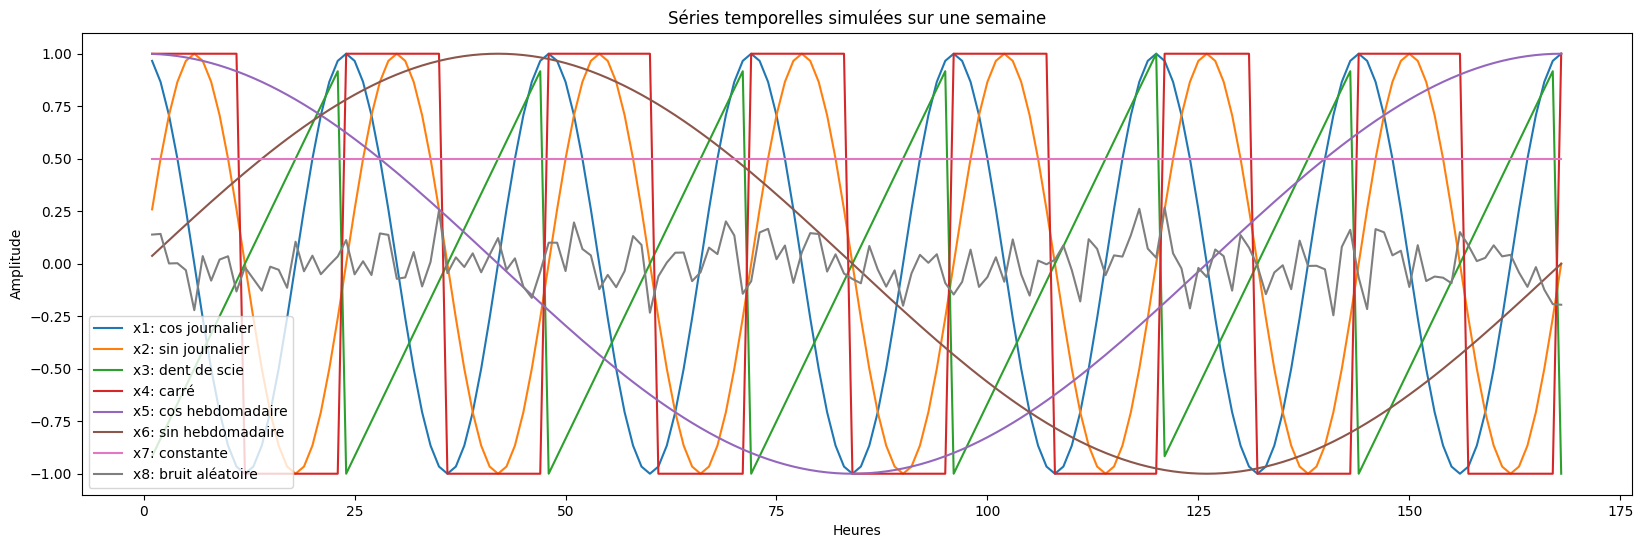

In [24]:
T=7*24                  #On regarde sur une semaine, avec pour pas de temps une heure.
t=np.linspace(1,T,T)    #t=[1,2,...,168]

x1 = np.cos(2*np.pi*t/24)                # cosinus journalier
x2 = np.sin(2*np.pi*t/24)                # sinus journalier
x3 = signal.sawtooth(2*np.pi*t/24)       # dent de scie quotidienne
x4 = signal.square(2*np.pi*t/24)         # signal carré quotidien
x5 = np.cos(2*np.pi*t/(24*7))            # cosinus hebdomadaire
x6 = np.sin(2*np.pi*t/(24*7))            # sinus hebdomadaire
x7 = np.ones_like(t)*0.5                 # constante
x8 = 0.1*np.random.randn(T)              # bruit aléatoire (petite amplitude)

# Plot
plt.figure(figsize=(20,6))
plt.plot(t, x1, label='x1: cos journalier')
plt.plot(t, x2, label='x2: sin journalier')
plt.plot(t, x3, label='x3: dent de scie')
plt.plot(t, x4, label='x4: carré')
plt.plot(t, x5, label='x5: cos hebdomadaire')
plt.plot(t, x6, label='x6: sin hebdomadaire')
plt.plot(t, x7, label='x7: constante')
plt.plot(t, x8, label='x8: bruit aléatoire')
plt.xlabel('Heures')
plt.ylabel('Amplitude')
plt.title('Séries temporelles simulées sur une semaine')
plt.legend()
plt.show()

On doit mainenant adapter la fonction Campbell :

In [26]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)
X=np.array([x1,x2,x3,x4,x5,x6,x7,x8])
Y=Simulateur(X,Z1,Z2)


ValueError: operands could not be broadcast together with shapes (64,64) (168,) 